# Pan01 surface fluxes

Variables:
- `wfo` = Water Flux Into Sea Water
   - Net surface water flux into the ocean, including precipitation, evaporation, river runoff, and sea ice melt/freeze. Positive into the ocean.
- `fsitherm` = water flux to ocean from sea ice melt(> 0) or form(< 0)
- `salt_flux` = Net salt flux into ocean at surface (restoring + sea-ice)
- `salt_flux_added` = Salt flux into ocean at surface due to restoring or flux adjustment
- `precip` = Liquid + frozen precipitation into ocean
- `lrunoff`= Liquid runoff (rivers) into ocean

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44043/status,
Dashboard: /proxy/44043/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34045,Workers: 0
Dashboard: /proxy/44043/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39635,Total threads: 1
Dashboard: /proxy/34709/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:38127,


In [3]:
# Importing data
pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ocean_month.nc'))[24:]
pathsM = np.sort(glob.glob('/scratch/x77/jn8053/mom6/archive/panant-01-zstar-ssp126-prsc-rest/*/*.ocean_month.nc'))

In [4]:
lat_slice = slice(None,-59)
time_slice = slice('2001-01-01','2010-12-31')

In [5]:
# Time variant variables
def preprocess_1(ds):
    ds = ds[['salt_flux_added','salt_flux','wfo','lrunoff']].sel(yh=lat_slice) 
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess_1, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess_1, chunks = 'auto')

In [6]:
cont = cont.sel(time= time_slice)
melt = melt.sel(time = time_slice)

In [3]:
# Area
area = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['areacello']
var = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_month_z.nc')['so'].isel(z_l=0,time=0)

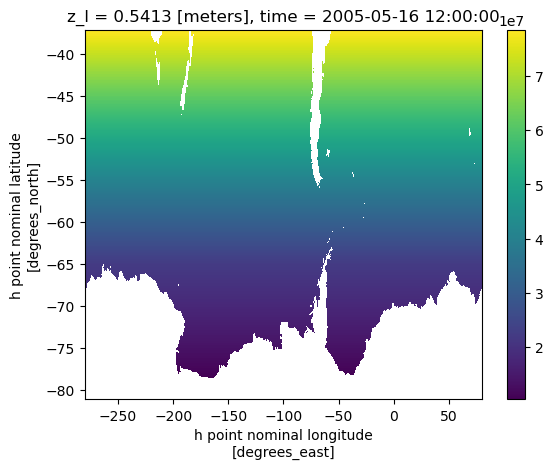

In [4]:
area_corr = area*(var*0 +1)
area_corr.plot()

In [5]:
# Shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [6]:
depth = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6_01')

# Water mass flux

 Let's look at water mass flux first.

In [11]:
water_C = cont['wfo']
water_M = melt['wfo']

Time series over shelf

In [12]:
water_shelf_C = water_C.where(shelf_mask ==1)
water_shelf_M = water_M.where(shelf_mask ==1)

In [13]:
# Spatial average
water_time_C = (area_corr * water_shelf_C).sum(['xh', 'yh']) / area_corr.where(shelf_mask == 1).sum(['xh', 'yh'])
water_time_M = (area_corr * water_shelf_M).sum(['xh', 'yh']) / area_corr.where(shelf_mask == 1).sum(['xh', 'yh'])

In [15]:
water_time_C = water_time_C.load()
water_time_M = water_time_M.load()

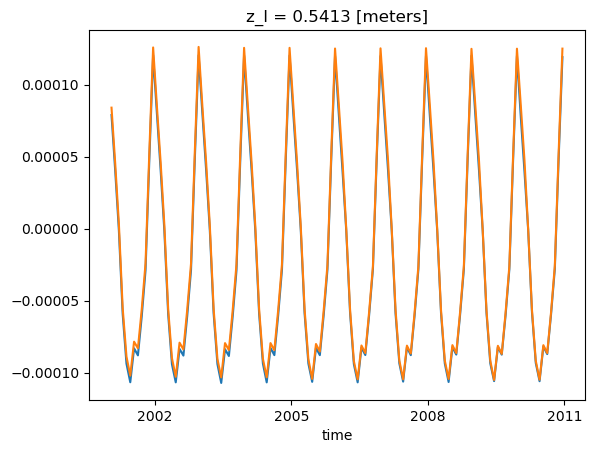

In [16]:
water_time_C.plot()
water_time_M.plot()

In [17]:
water_shelf_anom = water_time_M - water_time_C
water_shelf_anom = water_shelf_anom.load()

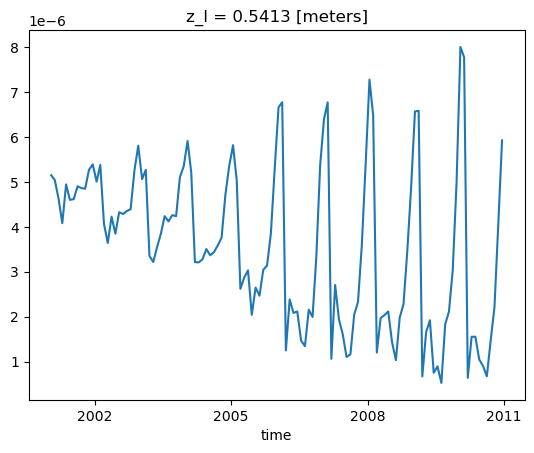

In [19]:
water_shelf_anom.plot()

In [20]:
water_shelf_anom.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/wfo_shelf_time_prescribed_Pan01.nc')

Oscillating around 5e-6, is this because of how the model drifts fresher?

### Quick comparison to ACCESS

In [26]:
wfo_shelf_pan = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/wfo_shelf_time_prescribed_Pan01.nc')
wfo_shelf_acc = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/wfo_shelf_time_prescribed_ACCESS.nc')

In [29]:
wfo_shelf_pan_new = wfo_shelf_pan.to_series()
wfo_shelf_acc_new = wfo_shelf_acc.to_series()

In [30]:
wfo_shelf_pan_new = wfo_shelf_pan_new['2001-01-01':'2010-12-16']
wfo_shelf_acc_new = wfo_shelf_acc_new['1910-01-01':'1919-12-16']

# Reset index to normalized months
wfo_shelf_pan_new.index = range(1, len(wfo_shelf_pan_new)+1)
wfo_shelf_acc_new.index = range(1, len(wfo_shelf_acc_new)+1)

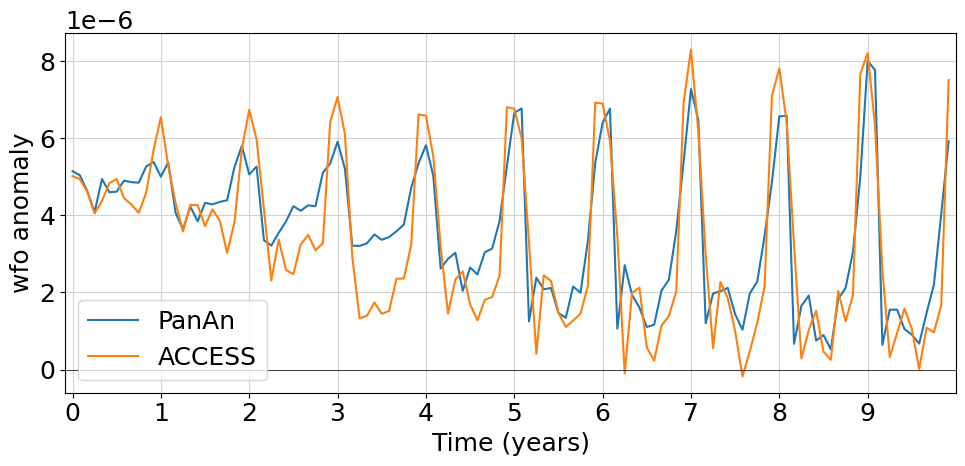

In [33]:
plt.rcParams['font.size'] = 18

plt.figure(figsize=(10, 5))
plt.plot(wfo_shelf_pan_new.index, wfo_shelf_pan_new.values, label='PanAn')
plt.plot(wfo_shelf_acc_new.index, wfo_shelf_acc_new.values, label='ACCESS')

# Set x-axis ticks to represent years 1 through 10
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(0, 10)])

# Labeling and formatting
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Time (years)')
plt.ylabel("wfo anomaly")
plt.title('')
plt.legend()
plt.xlim(0,121)
plt.grid(True, color='lightgrey')
plt.tight_layout()
plt.show()

Hm, the last 5 years is pretty similar for water mass flux.  
Now let's check salinity surface fluxes.

# Salinity surface flux

Components for surface flux:
- wfo (mass water flux) **-> converted to salt flux in restoring notebook**
- salt_flux (salt flux adaptive restoring?)
- salt_flux_added (salt flux prescribed restoring?)

In [11]:
# Load wfo converted into a salt flux
con_wfo = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/wfo_salt_con_prescribed_pan01.nc')
melt_wfo = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/wfo_salt_melt_prescribed_pan01.nc')

In [12]:
# loading salt flux from restoring (same as just cont['salt_flux_added']/melt['salt_flux_added'])
con_restore = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/restoring_con_prescribed_pan01.nc')
melt_restore = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/restoring_melt_prescribed_pan01.nc')

In [13]:
runoff_con = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/runoff_con_prescribed_pan01.nc')
runoff_melt = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/runoff_melt_prescribed_pan01.nc')

In [14]:
# Need to slice to match saved files
salt_C = cont['salt_flux'].sel(yh=slice(-79,-59)) + con_wfo + con_restore
salt_M = melt['salt_flux'].sel(yh=slice(-79,-59)) + melt_wfo + melt_restore

In [15]:
salt_shelf_C = salt_C.where(shelf_mask ==1)
salt_shelf_M = salt_M.where(shelf_mask ==1)

In [16]:
# Spatial average
salt_time_C = (area_corr * salt_shelf_C).sum(['xh', 'yh']) / area_corr.where(shelf_mask == 1).sum(['xh', 'yh'])
salt_time_M = (area_corr * salt_shelf_M).sum(['xh', 'yh']) / area_corr.where(shelf_mask == 1).sum(['xh', 'yh'])

In [17]:
# Testing in case correction term is included in salt_flux?
salt_C_new = cont['salt_flux'].sel(yh=slice(-79,-59)) + con_wfo
salt_M_new = melt['salt_flux'].sel(yh=slice(-79,-59)) + melt_wfo

In [18]:
salt_shelf_C_new = salt_C_new.where(shelf_mask ==1)
salt_shelf_M_new = salt_M_new.where(shelf_mask ==1)

In [19]:
salt_time_C_new = (area_corr * salt_shelf_C_new).sum(['xh', 'yh']) / area_corr.where(shelf_mask == 1).sum(['xh', 'yh'])
salt_time_M_new = (area_corr * salt_shelf_M_new).sum(['xh', 'yh']) / area_corr.where(shelf_mask == 1).sum(['xh', 'yh'])

In [14]:
salt_C_3 = cont['salt_flux'].sel(yh=slice(-79,-59)) + (con_wfo - runoff_con) + con_restore
salt_M_3 = melt['salt_flux'].sel(yh=slice(-79,-59)) + (melt_wfo - runoff_melt) + melt_restore

In [15]:
salt_shelf_C_3 = salt_C_3.where(shelf_mask ==1)
salt_shelf_M_3 = salt_M_3.where(shelf_mask ==1)

In [16]:
salt_time_C_3 = (area_corr * salt_shelf_C_3).sum(['xh', 'yh']) / area_corr.where(shelf_mask == 1).sum(['xh', 'yh'])
salt_time_M_3 = (area_corr * salt_shelf_M_3).sum(['xh', 'yh']) / area_corr.where(shelf_mask == 1).sum(['xh', 'yh'])

In [17]:
salt_time_C_3 = salt_time_C_3.load()

2025-10-14 19:54:07,020 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:46299
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/comm/tcp.py", line 226, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/worker.py", line 2073, in gather_dep
    response = await get_data_from_worker(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/worker.py", line 2879, in get_data_from_worker
    response = await send_recv(
       

In [18]:
salt_time_C_3.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_salt_time_C_3_prescribed_Pan01.nc')

In [19]:
salt_time_M_3 = salt_time_M_3.load()

2025-10-14 19:54:28,065 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.16 GiB -- Worker memory limit: 4.47 GiB
2025-10-14 19:54:30,048 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.59 GiB -- Worker memory limit: 4.47 GiB
2025-10-14 19:54:33,334 - distributed.worker.memory - WARNING - Worker is at 47% memory usage. Resuming worker. Process memory: 2.11 GiB -- Worker memory limit: 4.47 GiB
2025-10-14 19:54:36,375 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:40717
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_

In [20]:
salt_time_M_3.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_salt_time_M_3_prescribed_Pan01.nc')

#### Loading the flux files

In [21]:
salt_time_C = salt_time_C.load()

2025-10-14 16:36:24,567 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.58 GiB -- Worker memory limit: 4.47 GiB
2025-10-14 16:36:37,920 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:42093
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/comm/tcp.py", line 226, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/worker.py", line 2073, in gather_dep
    response = await get_data_from_worker(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/

In [23]:
salt_time_C.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_salt_time_C_prescribed_Pan01.nc')

In [20]:
salt_time_M = salt_time_M.load()

2025-10-14 16:52:46,952 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.15 GiB -- Worker memory limit: 4.47 GiB
2025-10-14 16:52:50,736 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.24 GiB -- Worker memory limit: 4.47 GiB
2025-10-14 16:52:54,242 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:40845
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/comm/tcp.py", line 231, in read
    

In [21]:
salt_time_M.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_salt_time_M_prescribed_Pan01.nc')

In [22]:
salt_time_C_new = salt_time_C_new.load()

2025-10-14 16:56:05,650 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:41013
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/comm/tcp.py", line 226, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/worker.py", line 2073, in gather_dep
    response = await get_data_from_worker(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/worker.py", line 2879, in get_data_from_worker
    response = await send_recv(
       

In [23]:
salt_time_C_new.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_salt_time_C_new_prescribed_Pan01.nc')

In [24]:
salt_time_M_new = salt_time_M_new.load()

In [25]:
salt_time_M_new.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_salt_time_M_new_prescribed_Pan01.nc')

In [26]:
salt_shelf_anom = salt_time_M - salt_time_C
salt_shelf_anom = salt_shelf_anom.load()

2025-10-14 16:56:35,180 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.24 GiB -- Worker memory limit: 4.47 GiB
2025-10-14 16:56:41,555 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:40539
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/comm/tcp.py", line 228, in read
    frames_nosplit = await read_bytes_rw(stream, frames_nosplit_nbytes)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/comm/tcp.py", line 367, in read_bytes_rw
    actual = await stream.read_into(chunk)  # type: ignore[arg-type

In [31]:
salt_shelf_anom_new = salt_time_M_new - salt_time_C_new
salt_shelf_anom_new = salt_shelf_anom_new.load()

In [32]:
salt_shelf_anom.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_shelf_time_prescribed_Pan01.nc')

In [33]:
salt_shelf_anom_new.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_shelf_time_prescribed_Pan01_new.nc')

#### Plotting the flux files

In [23]:
salt_time_C = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_salt_time_C_prescribed_Pan01.nc')
salt_time_M = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_salt_time_M_prescribed_Pan01.nc')
salt_time_C_new = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_salt_time_C_new_prescribed_Pan01.nc')
salt_time_M_new = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_salt_time_M_new_prescribed_Pan01.nc')
salt_time_C_3 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_salt_time_C_3_prescribed_Pan01.nc')
salt_time_M_3 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_salt_time_M_3_prescribed_Pan01.nc')

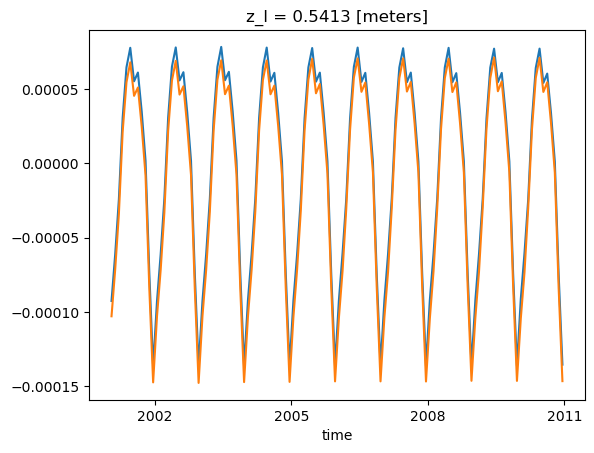

In [24]:
salt_time_C_3.plot(label = 'pan control')
salt_time_M_3.plot(label = 'pan melt')

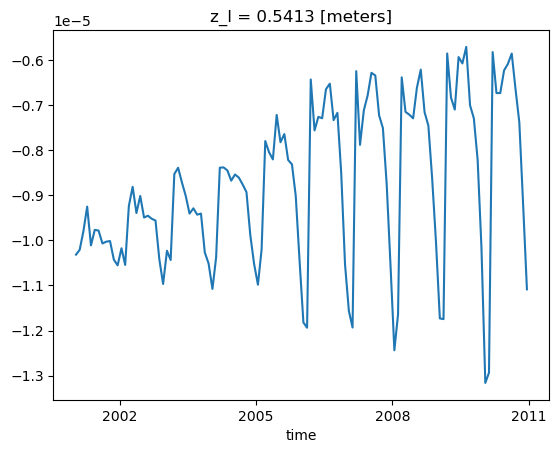

In [25]:
(salt_time_M_3 - salt_time_C_3).plot()

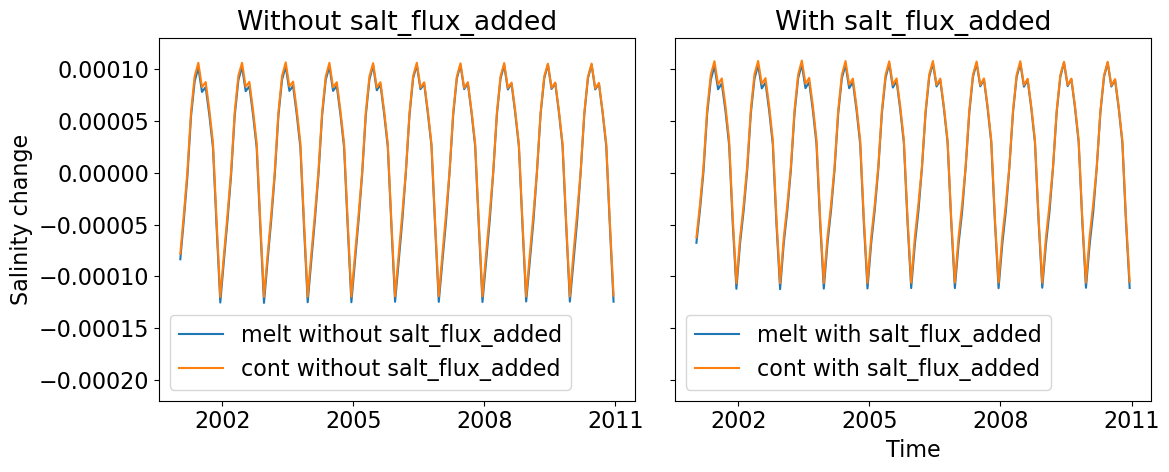

In [44]:
plt.rcParams['font.size'] = 16
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# --- Left plot: without salt_flux_added ---
ax = axes[0]
salt_time_M_new.plot(ax=ax, label='melt without salt_flux_added')
salt_time_C_new.plot(ax=ax, label='cont without salt_flux_added')
ax.set_ylim(-0.00022, 0.00013)
ax.legend()
ax.set_title('Without salt_flux_added')
ax.set_xlabel('')
ax.set_ylabel('Salinity change')

# --- Right plot: with salt_flux_added ---
ax = axes[1]
salt_time_M.plot(ax=ax, label='melt with salt_flux_added')
salt_time_C.plot(ax=ax, label='cont with salt_flux_added')
ax.set_ylim(-0.00022, 0.00013)
ax.legend()
ax.set_title('With salt_flux_added')
ax.set_xlabel('Time')

plt.tight_layout()
plt.show()

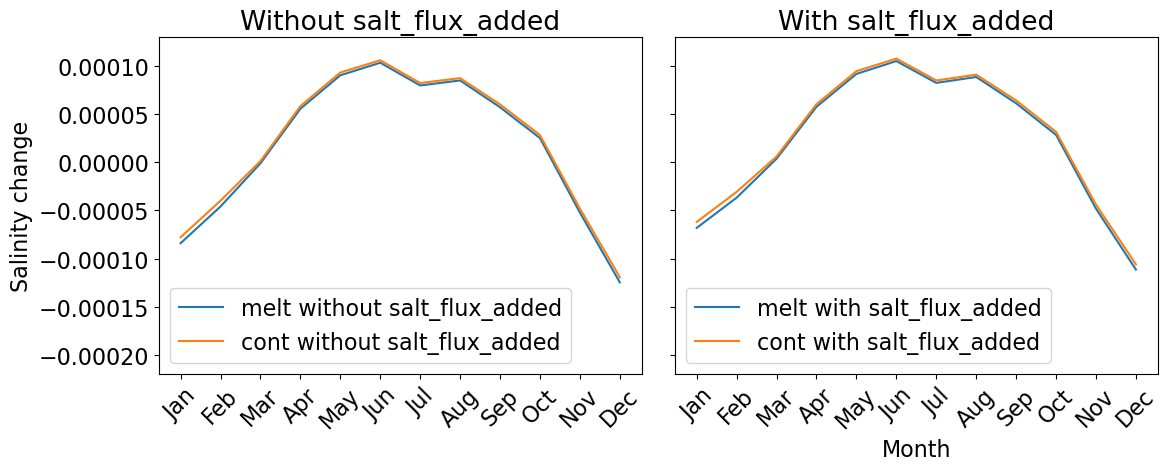

In [47]:
plt.rcParams['font.size'] = 16
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# --- Compute monthly climatology for xarray DataArrays ---
def monthly_climatology(da):
    """Return mean seasonal cycle (month-based climatology) for xarray DataArray."""
    return da.groupby('time.month').mean(dim='time')

# Compute climatologies
M_new_clim = monthly_climatology(salt_time_M_new)
C_new_clim = monthly_climatology(salt_time_C_new)
M_clim     = monthly_climatology(salt_time_M)
C_clim     = monthly_climatology(salt_time_C)

months = np.arange(1, 13)

# --- Left plot: without salt_flux_added ---
ax = axes[0]
ax.plot(months, M_new_clim, label='melt without salt_flux_added')
ax.plot(months, C_new_clim, label='cont without salt_flux_added')
ax.set_ylim(-0.00022, 0.00013)
ax.legend()
ax.set_title('Without salt_flux_added')
ax.set_xlabel('')
ax.set_ylabel('Salinity change')
ax.set_xticks(months)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)

# --- Right plot: with salt_flux_added ---
ax = axes[1]
ax.plot(months, M_clim, label='melt with salt_flux_added')
ax.plot(months, C_clim, label='cont with salt_flux_added')
ax.set_ylim(-0.00022, 0.00013)
ax.legend()
ax.set_title('With salt_flux_added')
ax.set_xlabel('Month')
ax.set_xticks(months)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)

plt.tight_layout()
plt.show()


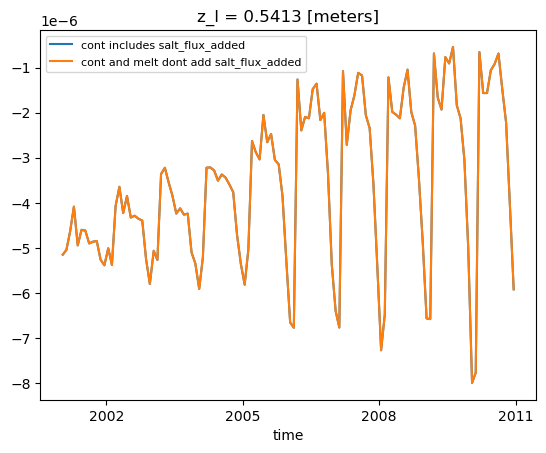

In [30]:
salt_shelf_anom.plot(label = 'cont includes salt_flux_added')
salt_shelf_anom_new.plot(label = 'cont and melt dont add salt_flux_added')
plt.legend(fontsize=8)

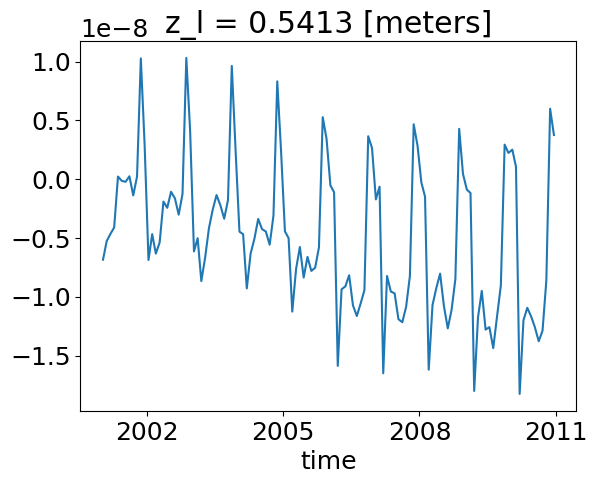

In [25]:
salt_shelf_anom.plot()

### Quick comparison to ACCESS

#### Old version

In [48]:
salt_shelf_pan = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_shelf_time_prescribed_Pan01_new.nc')
salt_shelf_acc = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_shelf_time_prescribed_ACCESS.nc')

In [49]:
salt_shelf_pan_new = salt_shelf_pan.to_series()
salt_shelf_acc_new = salt_shelf_acc.to_series()

salt_shelf_pan_new = salt_shelf_pan_new['2001-01-01':'2010-12-16']
salt_shelf_acc_new = salt_shelf_acc_new['1910-01-01':'1919-12-16']

# Reset index to normalized months
salt_shelf_pan_new.index = range(1, len(salt_shelf_pan_new)+1)
salt_shelf_acc_new.index = range(1, len(salt_shelf_acc_new)+1)

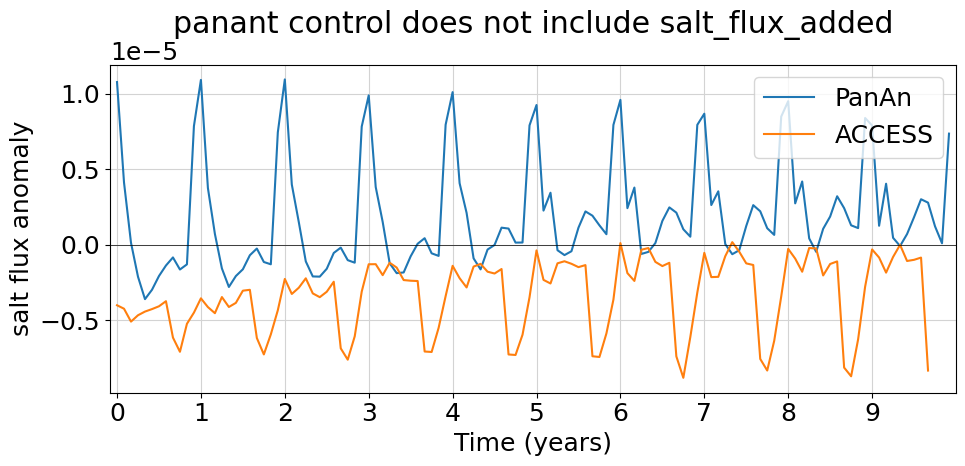

In [53]:
plt.rcParams['font.size'] = 18

plt.figure(figsize=(10, 5))
plt.plot(salt_shelf_pan_new.index, salt_shelf_pan_new.values, label='PanAn')
plt.plot(salt_shelf_acc_new.index, salt_shelf_acc_new.values, label='ACCESS')

# Set x-axis ticks to represent years 1 through 10
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(0, 10)])

# Labeling and formatting
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Time (years)')
plt.ylabel("salt flux anomaly")
plt.title('')
plt.legend()
plt.xlim(0,121)
plt.grid(True, color='lightgrey')
plt.title('panant control does not include salt_flux_added')
plt.tight_layout()
plt.show()


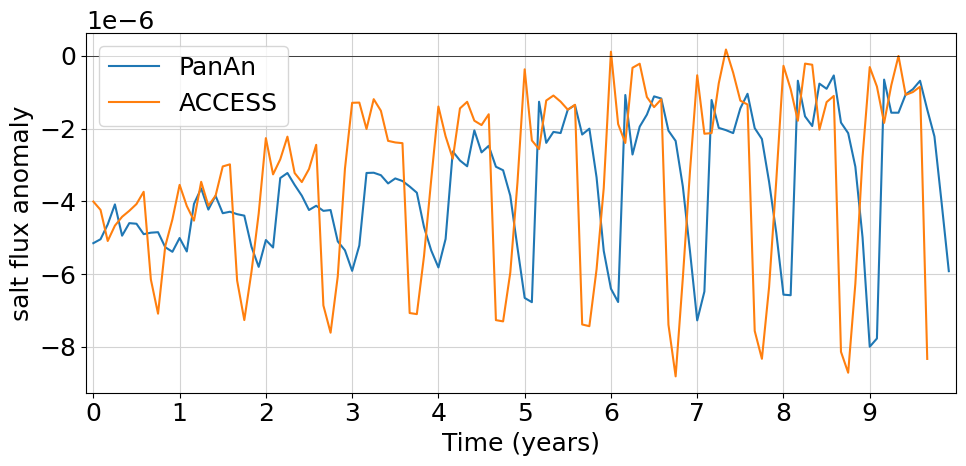

In [26]:
plt.rcParams['font.size'] = 18

plt.figure(figsize=(10, 5))
plt.plot(salt_shelf_pan_new.index, salt_shelf_pan_new.values, label='PanAn')
plt.plot(salt_shelf_acc_new.index, salt_shelf_acc_new.values, label='ACCESS')

# Set x-axis ticks to represent years 1 through 10
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(0, 10)])

# Labeling and formatting
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Time (years)')
plt.ylabel("salt flux anomaly")
plt.title('')
plt.legend()
plt.xlim(0,121)
plt.grid(True, color='lightgrey')
plt.tight_layout()
plt.show()

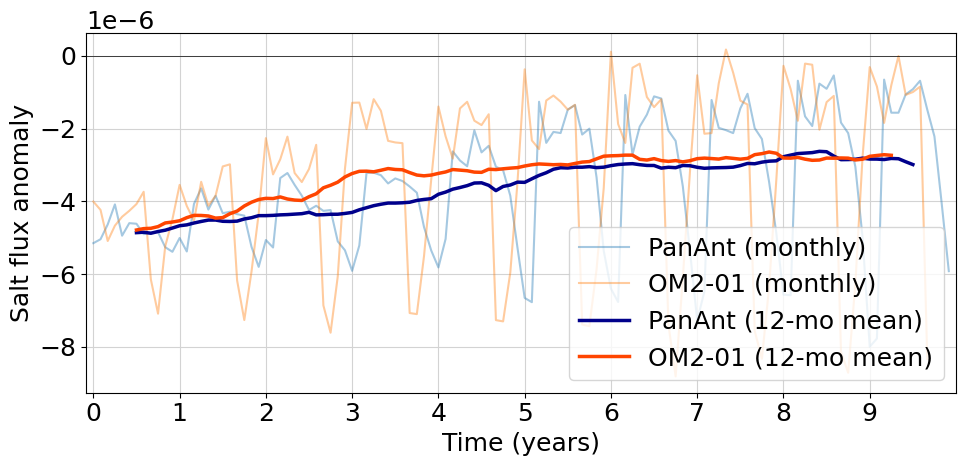

In [34]:
plt.rcParams['font.size'] = 18

plt.figure(figsize=(10, 5))

# Plot raw data
plt.plot(salt_shelf_pan_new.index, salt_shelf_pan_new.values, 
         label='PanAnt (monthly)', alpha=0.4)
plt.plot(salt_shelf_acc_new.index, salt_shelf_acc_new.values, 
         label='OM2-01 (monthly)', alpha=0.4)

# Compute and plot 12-month rolling mean
plt.plot(salt_shelf_pan_new.index, 
         salt_shelf_pan_new.rolling(window=12, center=True).mean(), 
         label='PanAnt (12-mo mean)', linewidth=2.5, color='darkblue')
plt.plot(salt_shelf_acc_new.index, 
         salt_shelf_acc_new.rolling(window=12, center=True).mean(), 
         label='OM2-01 (12-mo mean)', linewidth=2.5, color='orangered')

# Set x-axis ticks to represent years 0 through 10
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(0, 10)])

# Labeling and formatting
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Time (years)')
plt.ylabel('Salt flux anomaly')
plt.legend()
plt.xlim(0, 121)
plt.grid(True, color='lightgrey')
plt.tight_layout()
plt.show()


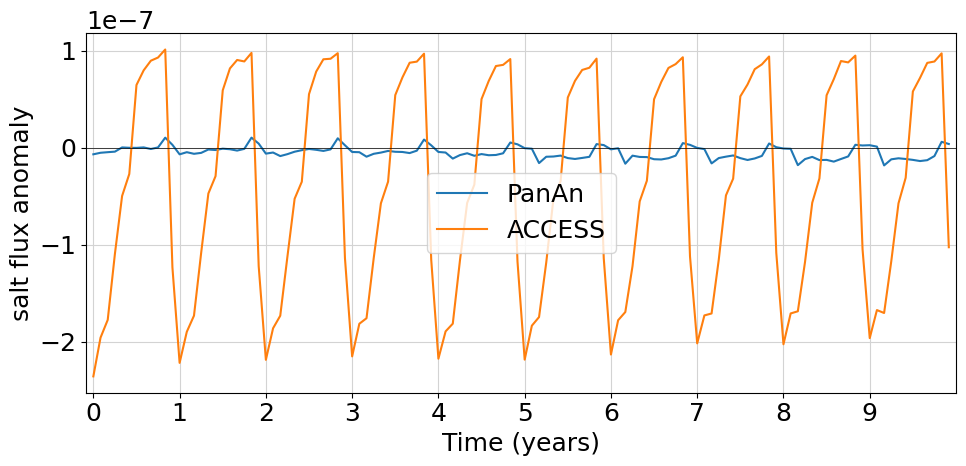

In [24]:
plt.rcParams['font.size'] = 18

plt.figure(figsize=(10, 5))
plt.plot(salt_shelf_pan_new.index, salt_shelf_pan_new.values, label='PanAn')
plt.plot(salt_shelf_acc_new.index, salt_shelf_acc_new.values, label='ACCESS')

# Set x-axis ticks to represent years 1 through 10
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(0, 10)])

# Labeling and formatting
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Time (years)')
plt.ylabel("salt flux anomaly")
plt.title('')
plt.legend()
plt.xlim(0,121)
plt.grid(True, color='lightgrey')
plt.tight_layout()
plt.show()

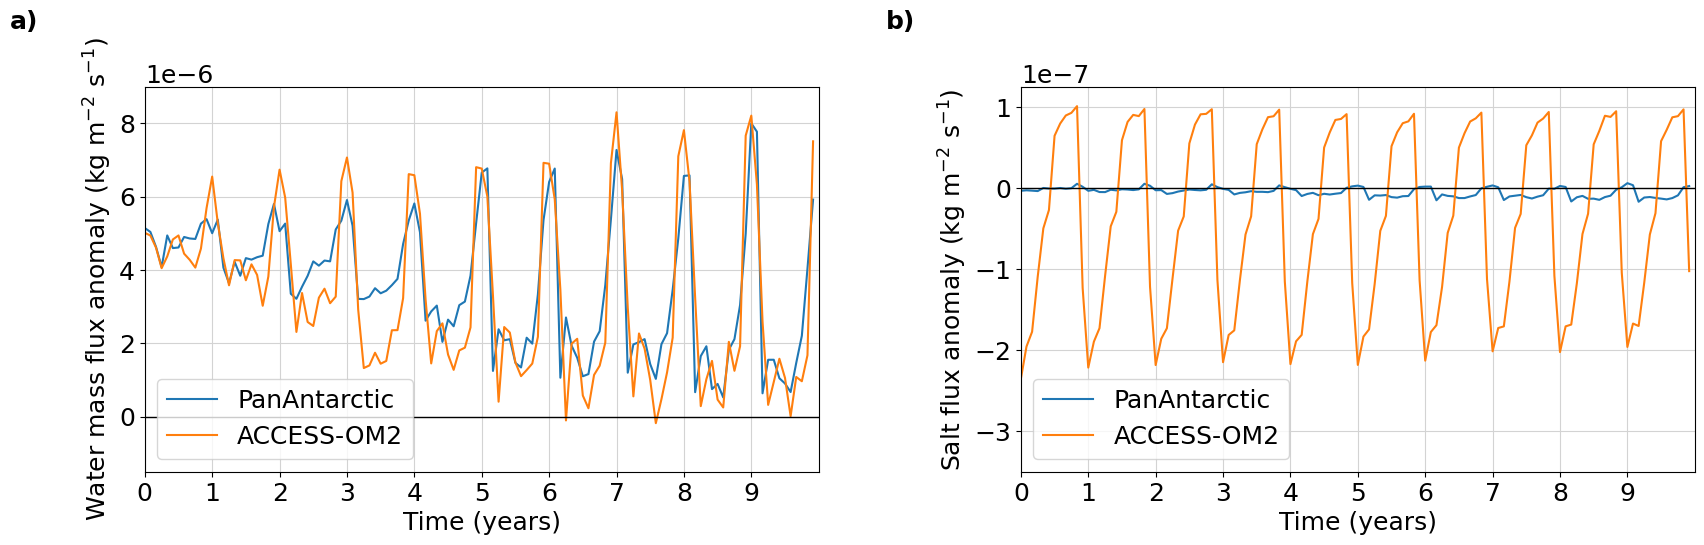

In [56]:
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 18

# Two panels: bottom and surface
datasets = [
    (wfo_shelf_pan_new, wfo_shelf_acc_new, "Water mass flux"),
    (salt_shelf_pan_new, salt_shelf_acc_new, "Salt flux"),
]

# Create figure with 2 subplots side by side
fig, axes = plt.subplots(
    nrows=1, ncols=2,
    figsize=(20, 5),
    constrained_layout=False
)

for i, (data1, data2, title) in enumerate(datasets):
    ax = axes[i]

    # Plot both resolutions
    ax.plot(data1.index, data1.values, label="PanAntarctic")
    ax.plot(data2.index, data2.values, label="ACCESS-OM2")

    # X ticks as years 1–10
    ax.set_xticks(range(1, 121, 12))
    ax.set_xticklabels([str(j) for j in range(0, 10)])

    # Horizontal zero line
    ax.axhline(0, color="black", linewidth=1)

    # Y-axis labels depend on subplot
    if i == 0:
        ax.set_ylabel("Water mass flux anomaly (kg m$^{-2}$ s$^{-1}$)")
        ax.set_ylim(-1.5e-6,9e-6)
    else:
        ax.set_ylabel("Salt flux anomaly (kg m$^{-2}$ s$^{-1}$)")
        ax.set_ylim(-3.5e-7,1.25e-7)

    # X-axis label
    ax.set_xlabel("Time (years)")
    ax.set_xlim(1,121)

    # Subplot labels (a), (b), etc.
    ax.text(-.2, 1.2, f"{chr(97+i)})", transform=ax.transAxes,
            fontsize=18, fontweight="bold", va="top", ha="left", color="black")

    # Legend + grid
    ax.legend(loc='lower left')
    ax.grid(True, color="lightgrey")

# Add space between subplots
plt.subplots_adjust(wspace=0.3)  # increase horizontal spacing (default ~0.2)

plt.show()

fig.savefig("/g/data/g40/kc5856/thesis_figures/intermodel_surfacefluxes_timeseries.png",
            dpi=300, bbox_inches='tight')

#### New version

In [26]:
pan_time_C = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_salt_time_C_3_prescribed_Pan01.nc')
pan_time_M = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_salt_time_M_3_prescribed_Pan01.nc')
acc_time_C = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_salt_time_C_3_prescribed_ACCESS.nc')
acc_time_M = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_salt_time_M_3_prescribed_ACCESS.nc')

In [30]:
pan_anom = pan_time_M - pan_time_C
acc_anom = acc_time_M - acc_time_C

In [31]:
pan_anom_new = pan_anom.to_series()
acc_anom_new = acc_anom.to_series()

pan_anom_new = pan_anom_new['2001-01-01':'2010-12-16']
acc_anom_new = acc_anom_new['1910-01-01':'1919-12-16']

# Reset index to normalized months
pan_anom_new.index = range(1, len(pan_anom_new)+1)
acc_anom_new.index = range(1, len(acc_anom_new)+1)

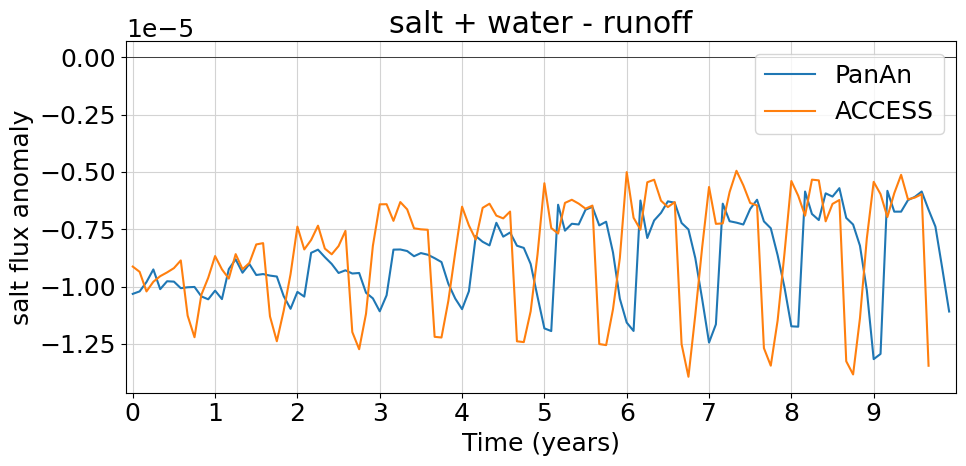

In [32]:
plt.rcParams['font.size'] = 18

plt.figure(figsize=(10, 5))
plt.plot(pan_anom_new.index, pan_anom_new.values, label='PanAn')
plt.plot(acc_anom_new.index, acc_anom_new.values, label='ACCESS')

# Set x-axis ticks to represent years 1 through 10
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(0, 10)])

# Labeling and formatting
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Time (years)')
plt.ylabel("salt flux anomaly")
plt.title('')
plt.legend()
plt.xlim(0,121)
plt.grid(True, color='lightgrey')
plt.title('salt + water - runoff')
plt.tight_layout()
plt.show()


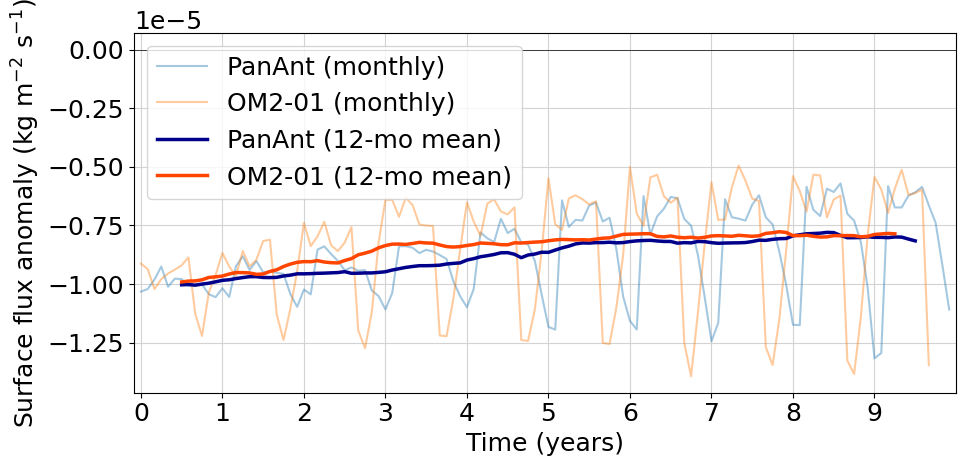

In [35]:
plt.rcParams['font.size'] = 18

plt.figure(figsize=(10, 5))

# Plot raw data
plt.plot(pan_anom_new.index, pan_anom_new.values, 
         label='PanAnt (monthly)', alpha=0.4)
plt.plot(acc_anom_new.index, acc_anom_new.values, 
         label='OM2-01 (monthly)', alpha=0.4)

# Compute and plot 12-month rolling mean
plt.plot(pan_anom_new.index, 
         pan_anom_new.rolling(window=12, center=True).mean(), 
         label='PanAnt (12-mo mean)', linewidth=2.5, color='darkblue')
plt.plot(acc_anom_new.index, 
         acc_anom_new.rolling(window=12, center=True).mean(), 
         label='OM2-01 (12-mo mean)', linewidth=2.5, color='orangered')

# Set x-axis ticks to represent years 0 through 10
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(0, 10)])

# Labeling and formatting
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Time (years)')
plt.ylabel('Surface flux anomaly (kg m$^{-2}$ s$^{-1}$)')
plt.legend()
plt.xlim(0, 121)
plt.grid(True, color='lightgrey')
plt.tight_layout()
plt.show()


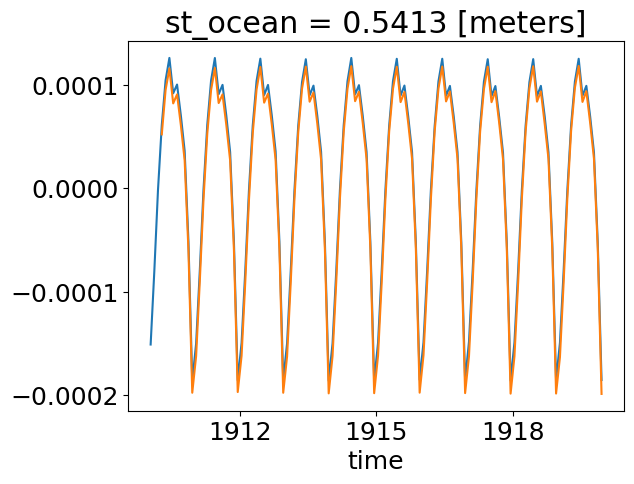

In [45]:
acc_time_C.plot()
acc_time_M.plot()

In [48]:
pan_time_C_new = pan_time_C.to_series()
pan_time_M_new = pan_time_M.to_series()
acc_time_C_new = acc_time_C.to_series()
acc_time_M_new = acc_time_M.to_series()

pan_time_C_new = pan_time_C_new['2001-01-01':'2010-12-16']
pan_time_M_new = pan_time_M_new['2001-01-01':'2010-12-16']
acc_time_C_new = acc_time_C_new['1910-01-01':'1919-12-16']
acc_time_M_new = acc_time_M_new['1910-01-01':'1919-12-16']

# Reset index to normalized months
pan_time_C_new.index = range(1, len(pan_time_C_new)+1)
pan_time_M_new.index = range(1, len(pan_time_M_new)+1)
acc_time_C_new.index = range(1, len(acc_time_C_new)+1)
acc_time_M_new.index = range(4, len(acc_time_M_new)+4) # +4 to correct melt run timing

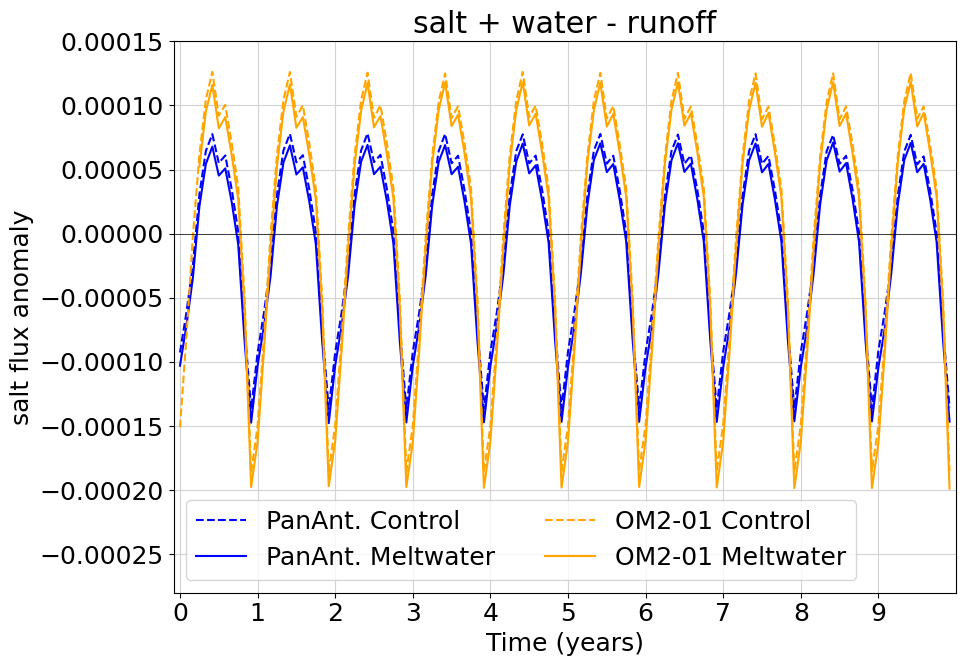

In [49]:
plt.rcParams['font.size'] = 18

plt.figure(figsize=(10, 7))
plt.plot(pan_time_C_new.index, pan_time_C_new.values, label='PanAnt. Control', color = 'b', linestyle = '--')
plt.plot(pan_time_M_new.index, pan_time_M_new.values, label = 'PanAnt. Meltwater', color = 'b', linestyle = '-')
plt.plot(acc_time_C_new.index, acc_time_C_new.values, label='OM2-01 Control',color = 'orange', linestyle = '--')
plt.plot(acc_time_M_new.index, acc_time_M_new.values, label = 'OM2-01 Meltwater',color = 'orange', linestyle = '-')

# Set x-axis ticks to represent years 1 through 10
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(0, 10)])

# Labeling and formatting
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Time (years)')
plt.ylabel("salt flux anomaly")
plt.title('')
plt.legend(ncols=2)
plt.xlim(0,121)
plt.ylim(-0.00028,0.00015)
plt.grid(True, color='lightgrey')
plt.title('salt + water - runoff')
plt.tight_layout()
plt.show()


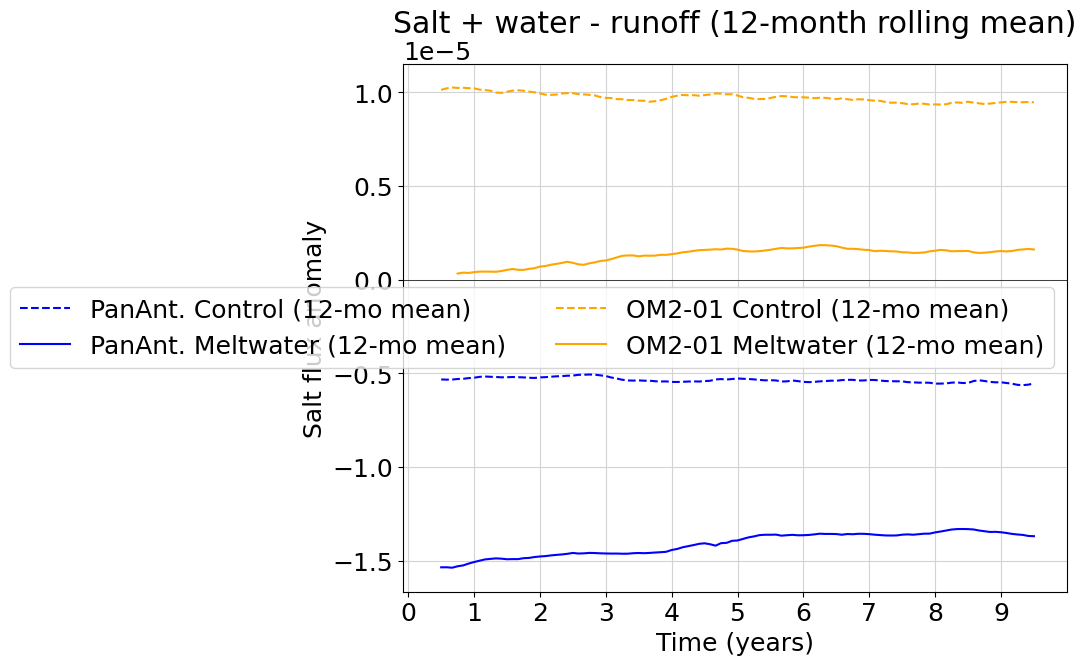

In [51]:
# --- Compute 12-month rolling means ---
pan_time_C_roll = pan_time_C_new.rolling(window=12, center=True).mean()
pan_time_M_roll = pan_time_M_new.rolling(window=12, center=True).mean()
acc_time_C_roll = acc_time_C_new.rolling(window=12, center=True).mean()
acc_time_M_roll = acc_time_M_new.rolling(window=12, center=True).mean()

# --- Plot ---
plt.rcParams['font.size'] = 18
plt.figure(figsize=(10, 7))

# PanAntarctic
plt.plot(pan_time_C_new.index, pan_time_C_roll.values, label='PanAnt. Control (12-mo mean)', color='b', linestyle='--')
plt.plot(pan_time_M_new.index, pan_time_M_roll.values, label='PanAnt. Meltwater (12-mo mean)', color='b', linestyle='-')

# ACCESS-OM2-01
plt.plot(acc_time_C_new.index, acc_time_C_roll.values, label='OM2-01 Control (12-mo mean)', color='orange', linestyle='--')
plt.plot(acc_time_M_new.index, acc_time_M_roll.values, label='OM2-01 Meltwater (12-mo mean)', color='orange', linestyle='-')

# --- Formatting ---
plt.axhline(0, color='black', linewidth=0.5)
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(0, 10)])
plt.xlabel('Time (years)')
plt.ylabel('Salt flux anomaly')
plt.legend(ncols=2)
plt.xlim(0, 121)
#plt.ylim(-0.00028, 0.00015)
plt.grid(True, color='lightgrey')
plt.title('Salt + water - runoff (12-month rolling mean)')
plt.tight_layout()
plt.show()


# Surface flux correct

What I currently have saved is:
- `salt_flux` - including ice and restoring. Is a salt flux.
- con_wfo = saved as a salt flux
- melt_wfo = saved as a salt flux
- con_restore = saved as a salt flux
- melt_restore = a salt flux
- runoff_con - saved as a freshwater flux (without negative)
- runoff_melt - saved as a freshwater flux (without negative)

Because all the ACCESS stuff is saved as a freshwater flux, that's what I'll do here too.  
What I will use:
- flux_ice_restore_con/flux_ice_restore_melt = `salt_flux` saved as a freshwater flux (ut negative)
- `wfo` - is a freshwater flux
- Not using 'restore' variable - this is already saved in `salt_flux`
- `lrunoff` - is a freshwater flux

In [ ]:
flux_ice_restore_melt = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/salt_flux_melt_asFWF_prescribed_pan01.nc')
flux_ice_restore_con = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/salt_flux_con_asFWF_prescribed_pan01.nc')

In [ ]:
surface_flux_C = flux_ice_restore_con + cont['wfo'].sel(yh=slice(-79,-59)) - cont['lrunoff'].sel(yh=slice(-79,-59))
surface_flux_M = flux_ice_restore_melt + melt['wfo'].sel(yh=slice(-79,-59)) - melt['lrunoff'].sel(yh=slice(-79,-59))

In [ ]:
shelf_flux_C = surface_flux_C.where(shelf_mask == 1)
shelf_flux_M = surface_flux_M.where(shelf_mask == 1)

In [ ]:
shelf_flux_C.isel(time=0).plot()

In [ ]:
# Spatial average
shelf_flux_time_C = (area_corr * shelf_flux_C).sum(['xh', 'yh']) / area_corr.where(shelf_mask == 1).sum(['xh', 'yh'])
shelf_flux_time_M = (area_corr * shelf_flux_M).sum(['xh', 'yh']) / area_corr.where(shelf_mask == 1).sum(['xh', 'yh'])

In [ ]:
shelf_flux_time_C

In [30]:
shelf_flux_time_C = shelf_flux_time_C.load()

In [31]:
shelf_flux_time_M = shelf_flux_time_M.load()

In [32]:
shelf_flux_time_C.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_shelf_time_C_newtest_prescribed_pan01.nc')
shelf_flux_time_M.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_shelf_time_M_newtest_prescribed_pan01.nc')

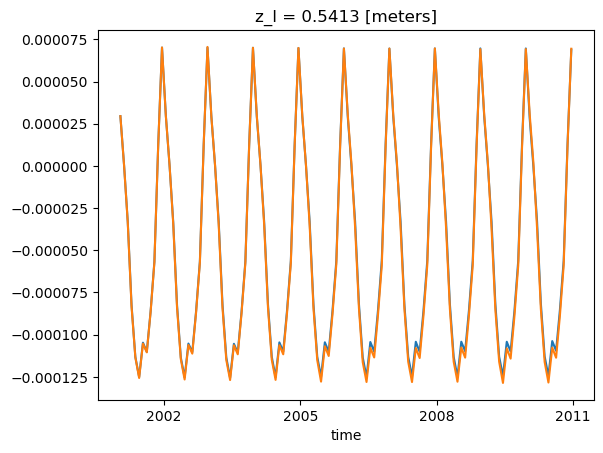

In [33]:
shelf_flux_time_C.plot()
shelf_flux_time_M.plot()

# Comparison to ACCESS

In [11]:
pan_flux_C = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_shelf_time_C_newtest_prescribed_pan01.nc')
pan_flux_M = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_shelf_time_M_newtest_prescribed_pan01.nc')
acc_flux_C = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_shelf_time_C_newtest_prescribed_ACCESS.nc')
acc_flux_M = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_shelf_time_M_newtest_prescribed_ACCESS.nc')

In [12]:
pan_flux_C_new = pan_flux_C.to_series()
pan_flux_M_new = pan_flux_M.to_series()
acc_flux_C_new = acc_flux_C.to_series()
acc_flux_M_new = acc_flux_M.to_series()

pan_flux_C_new = pan_flux_C_new['2001-01-01':'2010-12-16']
pan_flux_M_new = pan_flux_M_new['2001-01-01':'2010-12-16']
acc_flux_C_new = acc_flux_C_new['1910-01-01':'1919-12-16']
acc_flux_M_new = acc_flux_M_new['1910-01-01':'1919-12-16']

# Reset index to normalized months
pan_flux_C_new.index = range(1, len(pan_flux_C_new)+1)
pan_flux_M_new.index = range(1, len(pan_flux_M_new)+1)
acc_flux_C_new.index = range(1, len(acc_flux_C_new)+1)
acc_flux_M_new.index = range(4, len(acc_flux_M_new)+4) # +4 to correct melt run timing

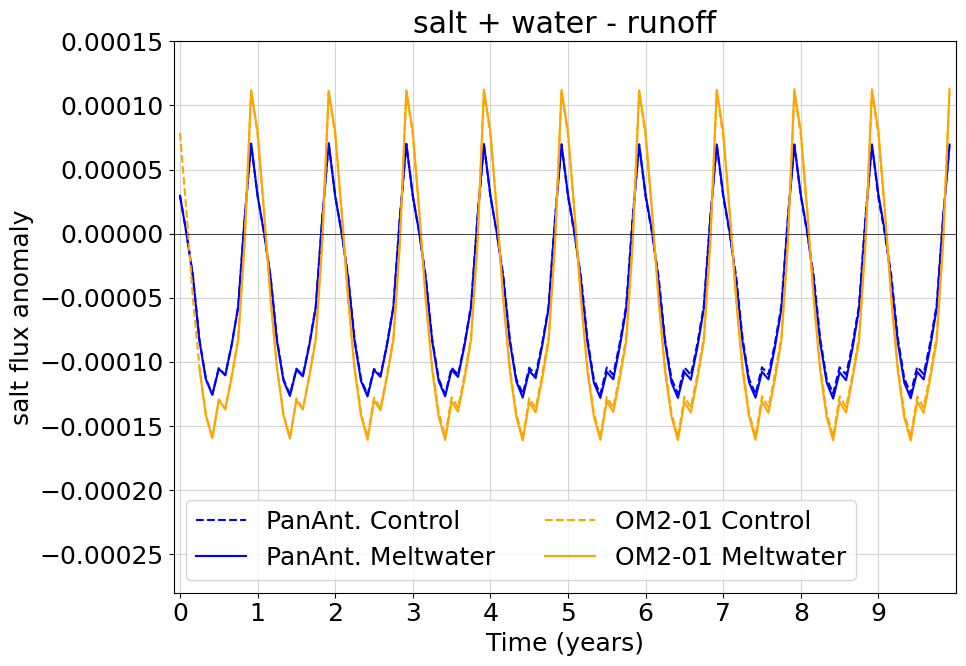

In [13]:
plt.rcParams['font.size'] = 18

plt.figure(figsize=(10, 7))
plt.plot(pan_flux_C_new.index, pan_flux_C_new.values, label='PanAnt. Control', color = 'b', linestyle = '--')
plt.plot(pan_flux_M_new.index, pan_flux_M_new.values, label = 'PanAnt. Meltwater', color = 'b', linestyle = '-')
plt.plot(acc_flux_C_new.index, acc_flux_C_new.values, label='OM2-01 Control',color = 'orange', linestyle = '--')
plt.plot(acc_flux_M_new.index, acc_flux_M_new.values, label = 'OM2-01 Meltwater',color = 'orange', linestyle = '-')

# Set x-axis ticks to represent years 1 through 10
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(0, 10)])

# Labeling and formatting
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Time (years)')
plt.ylabel("salt flux anomaly")
plt.title('')
plt.legend(ncols=2)
plt.xlim(0,121)
plt.ylim(-0.00028,0.00015)
plt.grid(True, color='lightgrey')
plt.title('salt + water - runoff')
plt.tight_layout()
plt.show()


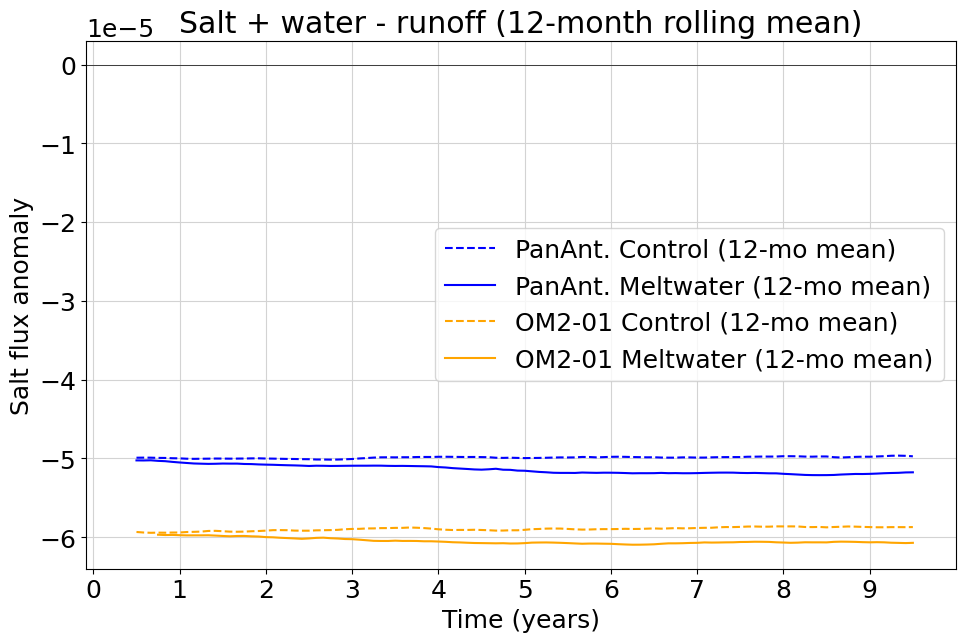

In [14]:
# --- Compute 12-month rolling means ---
pan_flux_C_roll = pan_flux_C_new.rolling(window=12, center=True).mean()
pan_flux_M_roll = pan_flux_M_new.rolling(window=12, center=True).mean()
acc_flux_C_roll = acc_flux_C_new.rolling(window=12, center=True).mean()
acc_flux_M_roll = acc_flux_M_new.rolling(window=12, center=True).mean()

# --- Plot ---
plt.rcParams['font.size'] = 18
plt.figure(figsize=(10, 7))

# PanAntarctic
plt.plot(pan_flux_C_new.index, pan_flux_C_roll.values, label='PanAnt. Control (12-mo mean)', color='b', linestyle='--')
plt.plot(pan_flux_M_new.index, pan_flux_M_roll.values, label='PanAnt. Meltwater (12-mo mean)', color='b', linestyle='-')

# ACCESS-OM2-01
plt.plot(acc_flux_C_new.index, acc_flux_C_roll.values, label='OM2-01 Control (12-mo mean)', color='orange', linestyle='--')
plt.plot(acc_flux_M_new.index, acc_flux_M_roll.values, label='OM2-01 Meltwater (12-mo mean)', color='orange', linestyle='-')

# --- Formatting ---
plt.axhline(0, color='black', linewidth=0.5)
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(0, 10)])
plt.xlabel('Time (years)')
plt.ylabel('Salt flux anomaly')
plt.legend(ncols=1)
plt.xlim(0, 121)
#plt.ylim(-0.00028, 0.00015)
plt.grid(True, color='lightgrey')
plt.title('Salt + water - runoff (12-month rolling mean)')
plt.tight_layout()
plt.show()


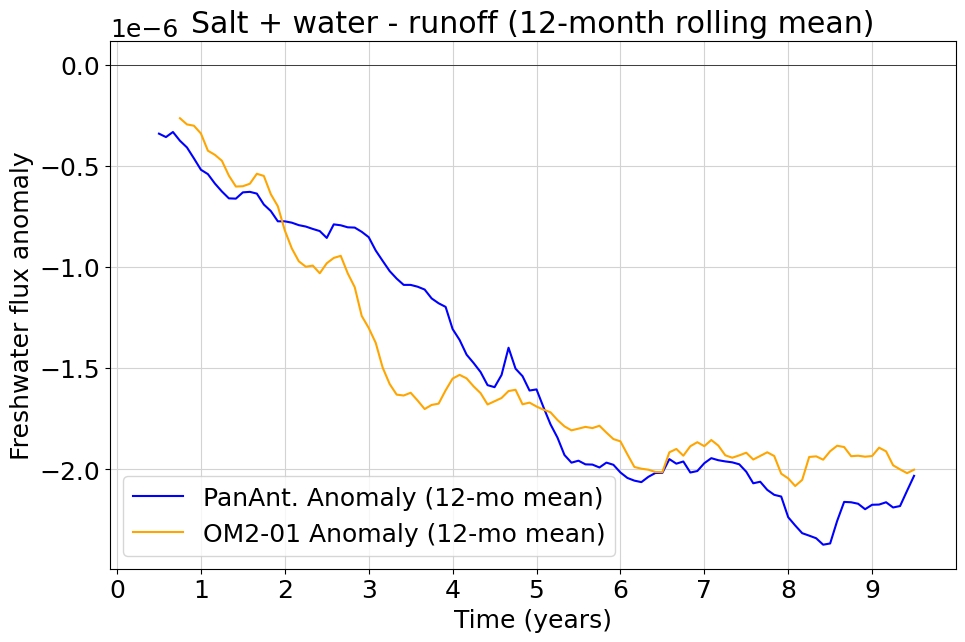

In [20]:
# --- Compute 12-month rolling means ---
pan_flux_C_roll = pan_flux_C_new.rolling(window=12, center=True).mean()
pan_flux_M_roll = pan_flux_M_new.rolling(window=12, center=True).mean()
acc_flux_C_roll = acc_flux_C_new.rolling(window=12, center=True).mean()
acc_flux_M_roll = acc_flux_M_new.rolling(window=12, center=True).mean()

# --- Plot ---
plt.rcParams['font.size'] = 18
plt.figure(figsize=(10, 7))

# PanAntarctic
plt.plot((pan_flux_M_new-pan_flux_C_new).index, (pan_flux_M_roll-pan_flux_C_roll).values, label='PanAnt. Anomaly (12-mo mean)', color='b', linestyle='-')
# ACCESS-OM2-01
plt.plot((acc_flux_M_new-acc_flux_C_new).index, (acc_flux_M_roll-acc_flux_C_roll).values, label='OM2-01 Anomaly (12-mo mean)', color='orange', linestyle='-')

# --- Formatting ---
plt.axhline(0, color='black', linewidth=0.5)
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(0, 10)])
plt.xlabel('Time (years)')
plt.ylabel('Freshwater flux anomaly')
plt.legend(ncols=1)
plt.xlim(0, 121)
#plt.ylim(-0.00028, 0.00015)
plt.grid(True, color='lightgrey')
plt.title('Salt + water - runoff (12-month rolling mean)')
plt.tight_layout()
plt.show()


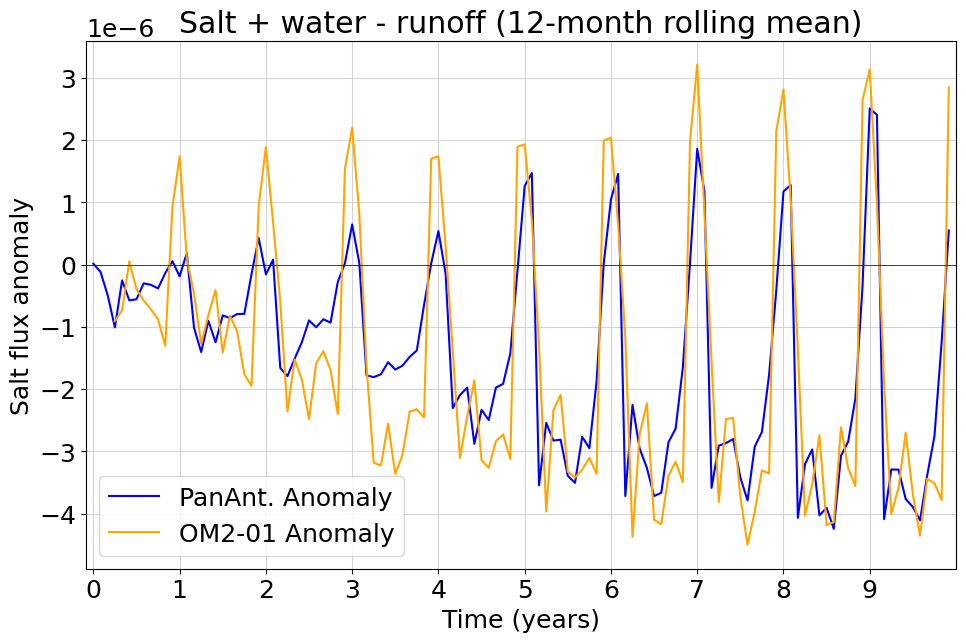

In [19]:
# --- Compute 12-month rolling means ---
pan_flux_C_roll = pan_flux_C_new.rolling(window=12, center=True).mean()
pan_flux_M_roll = pan_flux_M_new.rolling(window=12, center=True).mean()
acc_flux_C_roll = acc_flux_C_new.rolling(window=12, center=True).mean()
acc_flux_M_roll = acc_flux_M_new.rolling(window=12, center=True).mean()

# --- Plot ---
plt.rcParams['font.size'] = 18
plt.figure(figsize=(10, 7))

# PanAntarctic
plt.plot((pan_flux_M_new-pan_flux_C_new).index, (pan_flux_M_new-pan_flux_C_new).values, label='PanAnt. Anomaly', color='b', linestyle='-')
# ACCESS-OM2-01
plt.plot((acc_flux_M_new-acc_flux_C_new).index, (acc_flux_M_new-acc_flux_C_new).values, label='OM2-01 Anomaly', color='orange', linestyle='-')

# --- Formatting ---
plt.axhline(0, color='black', linewidth=0.5)
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(0, 10)])
plt.xlabel('Time (years)')
plt.ylabel('Salt flux anomaly')
plt.legend(ncols=1)
plt.xlim(0, 121)
#plt.ylim(-0.00028, 0.00015)
plt.grid(True, color='lightgrey')
plt.title('Salt + water - runoff (12-month rolling mean)')
plt.tight_layout()
plt.show()
